In [4]:
# Import modules

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as ss

import astropy.constants as con

import pymsg
import pygyre

# Set plot parameters

%matplotlib inline
plt.rcParams.update({'font.size': 16})

In [22]:
def synthesize_light_curve(phi, i, photgrid_name):
    
    # Create the PhotGrid object

    photgrid = pymsg.PhotGrid(photgrid_name)
    
    # Read the GYRE output file into a table

    tbl = pygyre.read_output('summary.h5')
    
    # Select the table row corresponding to the l=m=2, g_30 mode
    
    mask = (tbl['l'] == 2) & (tbl['m'] == 2) & (tbl['n_pg'] == -30)

    row = tbl[mask][0]
    
    # Extract stellar parameters

    M_star = row['M_star']
    R_star = row['R_star']
    L_star = row['L_star']

    Teff = (L_star/(4*np.pi*con.sigma_sb.cgs.value*R_star**2))**0.25
    g = con.G.cgs.value*M_star/R_star**2
                                  
    # Extract surface perturbation parameters      

    l = row['l']
    m = row['m']
    
    omega = row['omega']

    dR_R = row['xi_r_ref']      # Delta_R (T03, eqn. 4)
    dL_L = row['lag_L_ref']
    dT_T = 0.25*(dL_L - 2*dR_R) # Delta_T (T03, eqn. 5)
    dg_g = -(2 + omega**2)*dR_R # Delta_g (T03, eqn. 6)
    
    # Evaluate intensity moments & their partial derivatives (T03, eqn. 15)

    x = {'Teff': Teff, 'log(g)': np.log10(g)}

    I_0 = photgrid.D_moment(x, 0)
    I_x = photgrid.D_moment(x, l)

    dI_x_dlnT = photgrid.D_moment(x, l, deriv={'Teff': True}) * Teff
    dI_x_dlng = photgrid.D_moment(x, l, deriv={'log(g)': True}) * np.log(np.exp(1.))

    # Set up differential flux functions (T03, eqns. 12-14)

    R_lm = (2+l)*(1-l) * I_x/I_0 * ss.sph_harm(m, l, 0., i)
    T_lm = dI_x_dlnT/I_0 * ss.sph_harm(m, l, 0., i)
    G_lm = dI_x_dlng/I_0 * ss.sph_harm(m, l, 0., i)
    
    # Construct the light curve (T03, eqn. 11)

    dF_F = ((dR_R*R_lm + dT_T*T_lm + dg_g*G_lm) * np.exp(1j*phi)).real

    # Return it
    
    return dF_F

In [23]:
# Set up phase array

phi = np.linspace(0, 4*np.pi, 1001)

# Set observer inclination

i = np.radians(75)

# Evaluate light curves

dF_F_Kepler = synthesize_light_curve(phi, i, 'pg-Kepler.h5')
dF_F_TESS = synthesize_light_curve(phi, i, 'pg-TESS.h5')
dF_F_Gaia_B = synthesize_light_curve(phi, i, 'pg-Gaia-B.h5')
dF_F_Gaia_R = synthesize_light_curve(phi, i, 'pg-Gaia-R.h5')
dF_F_JWST = synthesize_light_curve(phi, i, 'pg-JWST.h5')

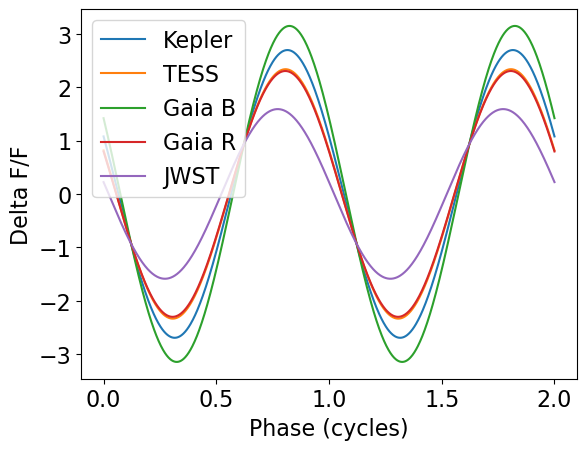

In [24]:
# Plot light curves

plt.figure()

plt.plot(phi/(2*np.pi), dF_F_Kepler, label='Kepler')
plt.plot(phi/(2*np.pi), dF_F_TESS, label='TESS')
plt.plot(phi/(2*np.pi), dF_F_Gaia_B, label='Gaia B')
plt.plot(phi/(2*np.pi), dF_F_Gaia_R, label='Gaia R')
plt.plot(phi/(2*np.pi), dF_F_JWST, label='JWST')

plt.xlabel('Phase (cycles)')
plt.ylabel('Delta F/F')
plt.legend()
